## Progetto Cerrito - Riconoscimento e Classificazione celllule malate di malaria

Import delle librerie necessarie al funzionamento del codice:

In [104]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import backend as K
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from PIL import Image
import matplotlib.transforms as mtransforms

Impostiamo alcune variabili necessarie al funzionamento del codice:

1. __train_data_dir__ ------------> La directory che contiene il dataset che utilizzeremo per fare in train del modello.
2. __validation_data_dir__ -------> La directory contenente il dataset per la valutazione del modello (alcune immagini su cui faremo delle previsioni)
3. __img_width, img_height__ -----> le dimensioni delle immagini con cui faremo lavorare il modello (rescaling delle stesse)
4. __nb_train_samples__ ----------> number of samples we want to use in training
5. __nb_validation_samples__ -----> number of samples we want to use for evaluating the model
6. __epochs__ --------------------> numero di epochs con cui faremo il training del modello
7. __batch_size__ ----------------> numero di samples che utilizzeremo per ogni singolo passo di training (weights adjustment)

In [2]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout("Son")
train_data_dir = os.path.join('cell_images', 'Dataset')
validation_data_dir = os.path.join('cell_images', 'Validation')

print(train_data_dir)

img_width, img_height = 124, 124
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 200
batch_size = 16

cell_images/Dataset


## Define the model

First we set the input shape depending on or backend __image_data_format__.

Initialize model with __Sequential()__ allows you to easily stack sequential layers of the network in order from input to output.



In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()

W0703 11:17:26.289039 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Next, we add a 2D convolutional layer to process input images.
We need to pass some arguments to the Conv2D() layer function:

1. The first argument is the number of outputs channels (as we have described in the model architecture).
2. Then we need to pass the kernel_size (as we have seen a 5x5 moving window) and the strides in x and y directions (1, 1).
3. We set the activation function as a rectified linear unit, and declare the input shape we defined before. (Input shape is only needed in the first layer)

In [4]:
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

W0703 11:17:26.334770 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 11:17:26.340975 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Next, we add a 2D max pooling layer.

In the __MaxPooling2D()__ function we need to define the size of the pooling (2, 2) and the strides in x and y directions (2, 2).

In [5]:
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

W0703 11:17:27.626300 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Then we add an additional conv+MaxPooling layer accordingly to our model architecture.

In [6]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

Aggiungiamo ancora una conv2d e MaxPooling2D

In [7]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

We have just finished building our convolutional layers, now we want to connect the output of convolutional layers to fully connected layers. 

First of all we need to flatten the output  with __Flatten()__ function.
Next we add two __Dense()__ (fully connected) layers declaring output and activation function.
Notice that the output of the final layer must match the number of category we whant to distinguish.
In our case 4 simpsons characters (bart, homer, lisa, marge).

In [8]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

W0703 11:17:31.156970 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0703 11:17:31.176141 140215874946880 deprecation.py:506] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Last step of our model definition is the __model.compile()__
here we need to pass some arguments:
1. the loss function we want to minimize (keras provides a lot of loss functions - see [here](https://keras.io/losses/))
2. an optimizer function to optimize our learning process (keras provides also a lot of loss functions - see [here](https://keras.io/optimizers/))
3. a metric for the model evaluation. (as before keras provides a lot of loss functions - see [here](https://keras.io/metrics/))

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0703 11:17:37.001334 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0703 11:17:37.041268 140215874946880 deprecation_wrapper.py:119] From /opt/conda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0703 11:17:37.051496 140215874946880 deprecation.py:323] From /opt/conda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Data augmentation for training

Keras provide us __ImageDataGenerator()__ class that let you generate always a fresh dataflow starting form a data directory to feed in our training-evaluating process.

The images taken from the train_data_dir are randomly manipulated and feeded in to the model.

This step is very important to provide a better training to the model.

Per convenzione vengono assegnate le seguenti label, a partire dalla directory di input:
1. unifected = 0
2. parasitized = 1

Applichiamo un split del dataset in per creare il dataset di test che corrisponde al 20% del dataset completo, applichiamo una seconda divisione del train set dividendolo al 50% tra train e validation, utilizzeremo il validation set per verificare il buon funzionamento della network in fase di predict.

In [25]:
data = []
uninfected = os.listdir(train_data_dir+"/Uninfected")
parasitized = os.listdir(train_data_dir+"/Parasitized")

for i in uninfected:
    data.append([train_data_dir+"/Uninfected/"+i,'Uninfected'])
for i in parasitized:
    data.append([train_data_dir+"/Parasitized/"+i,'Parasitized'])
random.shuffle(data)
image = [i[0] for i in data]
label = [i[1] for i in data]
del data

X_train, X_test, Y_train, Y_test = train_test_split(image, label, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=46)


In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

These are just a few of the options available (for more, see the documentation). Let's quickly go over what we just wrote:

rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
shear_range is for randomly applying shearing transformations
zoom_range is for randomly zooming inside pictures
horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [11]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Caricamento immagini da una directory (e relative sottodirectory)

Utilizzando il metodo flow_from_directory() passiamo tutti i dati al modello (caricamento massivo dei dati )secondo la struttura delle cartelle, facendo anche la resize delle immagini quando necessario.



In [116]:
x_train_dataframe = pd.DataFrame({'Filename':X_train, 'Label':Y_train})
x_testval_dataframe = pd.DataFrame({'Filename':X_test, 'Label':Y_test})
x_validation_dataframe = pd.DataFrame({'Filename':X_val, 'Label':Y_val})

x_train_dataframe.head(4)

,Filename,Label
0,cell_images/Dataset/Parasitized/C99P60ThinF_IM...,Parasitized
1,cell_images/Dataset/Parasitized/C59P20thinF_IM...,Parasitized
2,cell_images/Dataset/Parasitized/C180P141NThinF...,Parasitized
3,cell_images/Dataset/Uninfected/C70P31_ThinF_IM...,Uninfected


Creato il dataframe con la colonna path/filename e delle label associate, passiamo a creare (e a far caricare le immagini secondo i parametri associati a train_datagen) il modello.
Il parametro directory viene posto a None, visto che nell'X_train e nel X_test sono già specificati i percorsi per ogni immagine.

In [13]:
X_train_generator = train_datagen.flow_from_dataframe(dataframe = x_train_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))
X_testval_generator = train_datagen.flow_from_dataframe(dataframe = x_testval_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))

Found 22321 validated image filenames belonging to 2 classes.
Found 2756 validated image filenames belonging to 2 classes.


/opt/conda3/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

## Feed the model

With fit_generator() we start the training process. 
1. First of all we need to pass the training data as the first argument.
2. Then we declare the steps needed for each epoch, that will be obviously the number of training samples divided by the batch size.
3. Next the number of epochs we whant to train the model.
4. Then the validation data aka test datataset and the validation steps.

verbose=2 mostra la progress bar per ogni epoch.

In [16]:
savemod = 1
if os.path.exists('malaria_weights.h5') and os.path.exists('malaria_model_trained') and os.path.exists('validation_dataframe.csv'):
    history = load_model('malaria_model_trained')
    history.load_weights('malaria_weights.h5')
    x_validation_dataframe.read_csv('validation_dataframe.csv')
    savemod = 0

else:
    history = model.fit_generator(
        X_train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=X_testval_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 37s 297ms/step - loss: 0.6916 - acc: 0.5515 - val_loss: 0.6717 - val_acc: 0.6088
Epoch 2/50
125/125 [==============================] - 37s 294ms/step - loss: 0.6674 - acc: 0.6105 - val_loss: 0.6168 - val_acc: 0.6900
Epoch 3/50
125/125 [==============================] - 36s 291ms/step - loss: 0.6300 - acc: 0.6705 - val_loss: 0.5210 - val_acc: 0.7837
Epoch 4/50
125/125 [==============================] - 37s 292ms/step - loss: 0.5599 - acc: 0.7670 - val_loss: 0.4497 - val_acc: 0.8553
Epoch 5/50
125/125 [==============================] - 36s 286ms/step - loss: 0.4032 - acc: 0.8300 - val_loss: 0.3749 - val_acc: 0.8812
Epoch 6/50
125/125 [==============================] - 36s 289ms/step - loss: 0.3436 - acc: 0.8770 - val_loss: 0.2824 - val_acc: 0.8875
Epoch 7/50
125/125 [==============================] - 36s 285ms/step - loss: 0.3344 - acc: 0.8720 - val_loss: 0.3010 - val_acc: 0.8972
Epoch 8/50
125/125 [==============================] - 3

## Plot some graph
Saving the model training process to a history variable is usefull to plot the metrics in a graph.
In neural network training the training graph are the most usefull tool to benchmark our model and to do optimization of the architecture if needed.

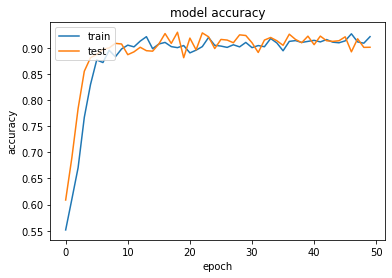

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Save the model

After such a long wait for the learning process to come to an end dont forget to save the trained model.
There are two way to save the model.
1. Save the model weights (that are the result of traing) without model architecture. (this option is used mainly to switch the model to another framework
2. Save the entire model (architecture and weights), so that it can be simply loaded up from keras.


In [ ]:
# Save weights for further use
if savemod:
    model.save_weights('malaria_weights.h5')
    model.save('malaria_model_trained')
    x_validation_dataframe.to_csv('validation_dataframe.csv')

Ora testiamo il modello sul dataset di test (nota che il dataset di test è generato randomicamente anche dopo il training del modello)
Selezioniamo rows * cols immagini dal dataset in maniera randomica e utilizziamo tale immagini per fare la predict su di loro. 

In [125]:
count=0
false_negative = 0
false_positive = 0

for row in x_validation_dataframe.itertuples(index=True, name='Pandas'):
    #print(getattr(row, "Filename"), getattr(row, "Label"))
    img = Image.open(getattr(row, "Filename"))
    label = getattr(row, "Label")
    img = img.convert("RGB")
    img = img.resize((img_width, img_height), Image.ANTIALIAS)
    img = img_to_array(img)
    img = img/255.0
    img = img.reshape((1,) + img.shape)
    pred = model.predict(img)
    pred = pred.item(0)
    pred = np.round(pred, decimals = 3)
    if pred > 0.500 and label == 'Parasitized':
        false_negative = false_negative + 1
    if pred <= 0.500 and label == 'Uninfected':
        false_positive = false_positive + 1
    count=count + 1
    if count >1000:
        break;
print("False Negative: ", false_negative)
print("False Positive: ", false_positive)
"""
rows = 10
cols = 5
ig, ax = plt.subplots(rows, cols, figsize=(24, 24))
toRnd = np.random.randint(low = 0, high = len(X_test), size = rows * cols)
count=0
plt.figure(figsize=(64,64))
for i in range(rows):
    for j in range(cols):
        charstr=''
        img = Image.open(X_test[toRnd[i+j]])
        ax[i][j].imshow(img)
        img = img.convert("RGB")
        img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img_to_array(img)
        img = img/255.0
        img = img.reshape((1,) + img.shape)
        pred = model.predict(img)
        pred = pred.item(0)
        pred = np.round(pred, decimals = 3)
        charstr = 'Uninfected: '+ str(pred) + '\nInfected: ' + str(np.round(1-pred, decimals = 3)) +'\nOrig. Label: ' + Y_test[toRnd[i+j]]
        ec = (0, .8, .1)
        fc = (0, .9, .2)
        count = count + 1
        ax[i][j].text(0, -10, charstr, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc, alpha = 1))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
"""

False Negative:  41
False Positive:  10


'\nrows = 10\ncols = 5\nig, ax = plt.subplots(rows, cols, figsize=(24, 24))\ntoRnd = np.random.randint(low = 0, high = len(X_test), size = rows * cols)\ncount=0\nplt.figure(figsize=(64,64))\nfor i in range(rows):\n    for j in range(cols):\n        charstr=\'\'\n        img = Image.open(X_test[toRnd[i+j]])\n        ax[i][j].imshow(img)\n        img = img.convert("RGB")\n        img = img.resize((img_width, img_height), Image.ANTIALIAS)\n        img = img_to_array(img)\n        img = img/255.0\n        img = img.reshape((1,) + img.shape)\n        pred = model.predict(img)\n        pred = pred.item(0)\n        pred = np.round(pred, decimals = 3)\n        charstr = \'Uninfected: \'+ str(pred) + \'\nInfected: \' + str(np.round(1-pred, decimals = 3)) +\'\nOrig. Label: \' + Y_test[toRnd[i+j]]\n        ec = (0, .8, .1)\n        fc = (0, .9, .2)\n        count = count + 1\n        ax[i][j].text(0, -10, charstr, size=10, rotation=0,\n                ha="left", va="top", \n                bbox=d